In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.7 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler  # Using RandomOverSampler instead
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter



In [12]:
# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [13]:
# Load dataset
df = pd.read_excel("xp.xlsx")
# Plot class distribution before resampling
# Plot class distribution before resampling
plt.figure(figsize=(8, 5))
sns.countplot(x=y, palette="Set2")
plt.title("Class Distribution Before Resampling")
plt.xlabel("Treatment Outcome")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_distribution_before_resampling.png", dpi=300)
plt.close()

/tmp/ipython-input-2419231038.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Set2")


In [14]:
# Prepare features and target
target_col = "treatments.treatment_outcome"
X = df.drop(columns=[target_col])
y = df[target_col]

In [15]:
# Identify categorical columns
cat_features = X.select_dtypes(include="object").columns.tolist()
print(f"Categorical features: {cat_features}")

Categorical features: ['demographic.gender', 'diagnoses.ajcc_pathologic_m', 'diagnoses.ajcc_pathologic_n', 'diagnoses.ajcc_pathologic_stage', 'diagnoses.ajcc_pathologic_t', 'diagnoses.ajcc_staging_system_edition', 'diagnoses.icd_10_code', 'diagnoses.primary_diagnosis', 'diagnoses.residual_disease', 'diagnoses.tissue_or_organ_of_origin', 'treatments.therapeutic_agents', 'treatments.treatment_type']


In [16]:
# Show original class distribution
print("\nOriginal class distribution:")
print(y.value_counts(normalize=True))


Original class distribution:
treatments.treatment_outcome
Complete Response      0.524390
Progressive Disease    0.250000
Stable Disease         0.128049
Partial Response       0.097561
Name: proportion, dtype: float64


In [17]:
# For resampling, encode categoricals as numeric codes
X_encoded = X.copy()
for col in cat_features:
    X_encoded[col] = X_encoded[col].astype('category').cat.codes

In [19]:
# Apply RandomOverSampler
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_resampled, y_resampled = ros.fit_resample(X_encoded, y)
print("\nResampled class distribution:")
print(pd.Series(y_resampled).value_counts(normalize=True))


Resampled class distribution:
treatments.treatment_outcome
Complete Response      0.25
Progressive Disease    0.25
Partial Response       0.25
Stable Disease         0.25
Name: proportion, dtype: float64


In [20]:
# Plot class distribution after resampling
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled, palette="Set1")
plt.title("Class Distribution After Random OverSampling")
plt.xlabel("Treatment Outcome")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("class_distribution_after_resampling.png", dpi=300)
plt.close()

/tmp/ipython-input-1056841288.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, palette="Set1")


In [21]:
# Convert back to categorical for CatBoost
X_resampled_cat = X_resampled.copy()
for col in cat_features:
    original_categories = X[col].astype('category').cat.categories
    X_resampled_cat[col] = pd.Categorical.from_codes(
        X_resampled[col].astype(int),
        categories=original_categories
    )

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled_cat, y_resampled, test_size=0.2, random_state=RANDOM_STATE, stratify=y_resampled
)
# Optimized CatBoost parameters for accuracy and reduced overfitting
params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'depth': 4,
    'l2_leaf_reg': 10,
    'border_count': 64,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 150,
    'use_best_model': True,
    'random_seed': RANDOM_STATE,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'min_data_in_leaf': 5,
    'max_ctr_complexity': 2,
    'grow_policy': 'SymmetricTree',
    'od_type': 'IncToDec',
    'verbose': 100
}

In [23]:
# Enhanced cross-validation with accuracy tracking
def cross_validate_catboost(X, y, cat_features, params, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    models = []
    accuracies = []
    f1_scores = []
    best_model = None
    best_accuracy = 0

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n=== Training Fold {fold+1}/{n_splits} ===")

        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        train_pool = Pool(X_train_fold, y_train_fold, cat_features=cat_features)
        val_pool = Pool(X_val_fold, y_val_fold, cat_features=cat_features)

        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool)

        y_pred = model.predict(X_val_fold)
        fold_accuracy = accuracy_score(y_val_fold, y_pred)
        fold_f1 = f1_score(y_val_fold, y_pred, average='macro')

        accuracies.append(fold_accuracy)
        f1_scores.append(fold_f1)
        models.append(model)

        print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")
        print(f"Fold {fold+1} F1 Score: {fold_f1:.4f}")
        print(f"Best Iteration: {model.best_iteration_}")

        if fold_accuracy > best_accuracy:
            best_accuracy = fold_accuracy
            best_model = model

    print("\nCross-Validation Results:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f} (±{np.std(accuracies):.4f})")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
    print(f"Accuracy Range: {min(accuracies):.4f}-{max(accuracies):.4f}")

    return best_model, models, accuracies

In [24]:

# Run cross-validation
best_model, models, cv_accuracies = cross_validate_catboost(
    X_resampled_cat, y_resampled, cat_features, params
)


=== Training Fold 1/5 ===
0:	learn: 0.4581818	test: 0.3188406	best: 0.3188406 (0)	total: 5.55ms	remaining: 11.1s
100:	learn: 0.7890909	test: 0.8550725	best: 0.8695652 (65)	total: 450ms	remaining: 8.46s
200:	learn: 0.8327273	test: 0.8695652	best: 0.8695652 (65)	total: 862ms	remaining: 7.72s
300:	learn: 0.8509091	test: 0.9275362	best: 0.9275362 (261)	total: 1.3s	remaining: 7.32s
400:	learn: 0.8581818	test: 0.9275362	best: 0.9275362 (261)	total: 1.73s	remaining: 6.88s
500:	learn: 0.8690909	test: 0.9420290	best: 0.9420290 (422)	total: 2.17s	remaining: 6.48s
600:	learn: 0.8800000	test: 0.9420290	best: 0.9420290 (422)	total: 2.62s	remaining: 6.11s
700:	learn: 0.9018182	test: 0.9420290	best: 0.9420290 (422)	total: 3.1s	remaining: 5.75s
800:	learn: 0.9054545	test: 0.9565217	best: 0.9565217 (772)	total: 3.57s	remaining: 5.34s
900:	learn: 0.9054545	test: 0.9710145	best: 0.9710145 (839)	total: 4.04s	remaining: 4.92s
1000:	learn: 0.9236364	test: 0.9710145	best: 0.9710145 (839)	total: 4.49s	remain

In [25]:

# Evaluate on test set
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

In [26]:
# Training set evaluation for overfitting check
y_train_pred = best_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')

In [27]:
# Feature importance
feature_importance = best_model.get_feature_importance()
feature_names = X_train.columns
print("\nTop Predictive Features:")
for score, name in sorted(zip(feature_importance, feature_names), reverse=True)[:10]:
    print(f"{name}: {score:.2f}")


Top Predictive Features:
demographic.age_at_index: 16.75
diagnoses.ajcc_pathologic_stage: 15.17
diagnoses.ajcc_pathologic_t: 14.37
diagnoses.primary_diagnosis: 11.43
diagnoses.ajcc_pathologic_m: 9.06
diagnoses.ajcc_pathologic_n: 6.82
diagnoses.icd_10_code: 6.41
treatments.therapeutic_agents: 5.68
diagnoses.tissue_or_organ_of_origin: 5.60
diagnoses.residual_disease: 3.65


In [28]:
# Results
print("\n=== Test Set Performance ===")
print(classification_report(y_test, y_pred))

print("\nModel Performance Summary:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Accuracy Gap: {train_accuracy-test_accuracy:.4f}")
print(f"\nTrain F1: {train_f1:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"F1 Gap: {train_f1-test_f1:.4f}")


=== Test Set Performance ===
                     precision    recall  f1-score   support

  Complete Response       0.94      0.88      0.91        17
   Partial Response       0.94      1.00      0.97        17
Progressive Disease       0.94      0.83      0.88        18
     Stable Disease       0.89      1.00      0.94        17

           accuracy                           0.93        69
          macro avg       0.93      0.93      0.93        69
       weighted avg       0.93      0.93      0.93        69


Model Performance Summary:
Train Accuracy: 0.9309
Test Accuracy: 0.9275
Accuracy Gap: 0.0034

Train F1: 0.9302
Test F1: 0.9268
F1 Gap: 0.0034


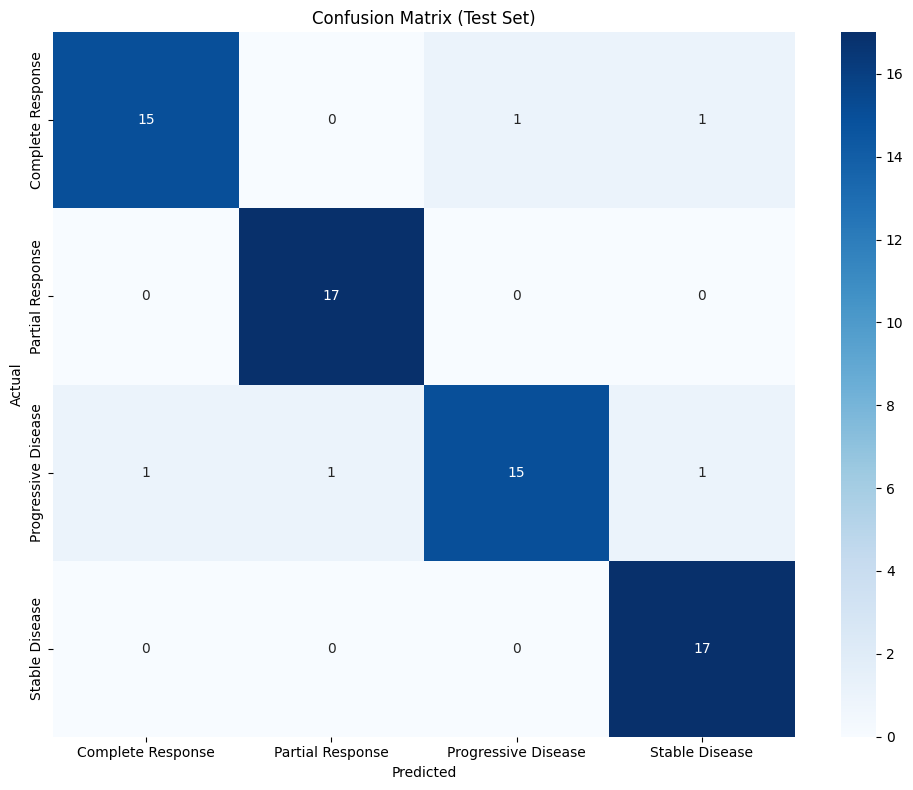

In [29]:
# Confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()